In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:/Papers/paper_code/new/Data/Processed/Tesla_data.csv')

In [3]:
data.head(3)

,Date,Close,lag_O,lag_H,lag_L,lag_C,lag_A,Year,Month,Day,Weekday
0,2010-07-02,0.000554,0.000465,0.001350,0.000422,0.001319,0.001319,0.0,0.545455,0.033333,1.00
1,2010-07-06,0.000051,0.001568,0.002224,0.001371,0.001309,0.001309,0.0,0.545455,0.166667,0.25
2,2010-07-07,0.000000,0.001439,0.001498,0.000871,0.001004,0.001004,0.0,0.545455,0.200000,0.50


In [4]:
data.shape

(3140, 11)

In [5]:
train = data[:-92]
test = data[-92:]
print(train.shape)
print(test.shape)

(3048, 11)
(92, 11)


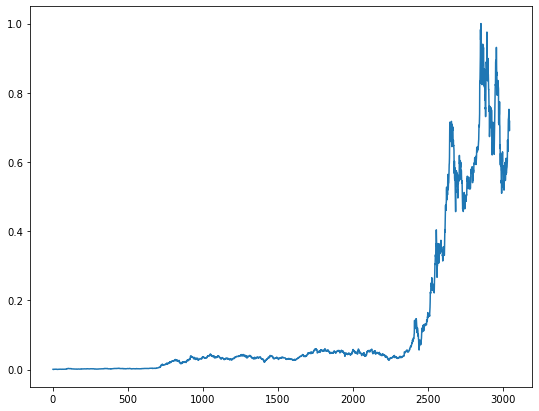

In [8]:
sns.reset_orig()
plt.figure(figsize = (9,7))
#plt.title('Tesla Stock', fontsize = 24)
plt.plot(train['Close'], label = 'train')
#plt.plot(test['Close'], label = 'test')

#plt.legend()
plt.show()

In [7]:
x_train = train.drop(columns = {'Date','Close'}, axis = 1)
y_train = train.loc[:, ['Close']]

x_test = test.drop(columns = {'Date','Close'}, axis = 1)
y_test = test.loc[:, ['Close']]

In [8]:
import xgboost

In [9]:
model = xgboost.XGBRegressor().fit(x_train, y_train)

pred = model.predict(x_test)

In [10]:
def slide_pred(lag_n, pred):
    prediction = list(pred)
    prediction = prediction[lag_n:]
        
    return prediction

In [11]:
pred = slide_pred(3, pred)
y_test = y_test[:-3]

In [12]:
r2 = r2_score(pred, y_test)
mse = mean_squared_error(pred, y_test)

print('R2: ', r2, '  ;  ', 'MSE: ', mse)

R2:  0.7631942904849754   ;   MSE:  0.002920607101243879


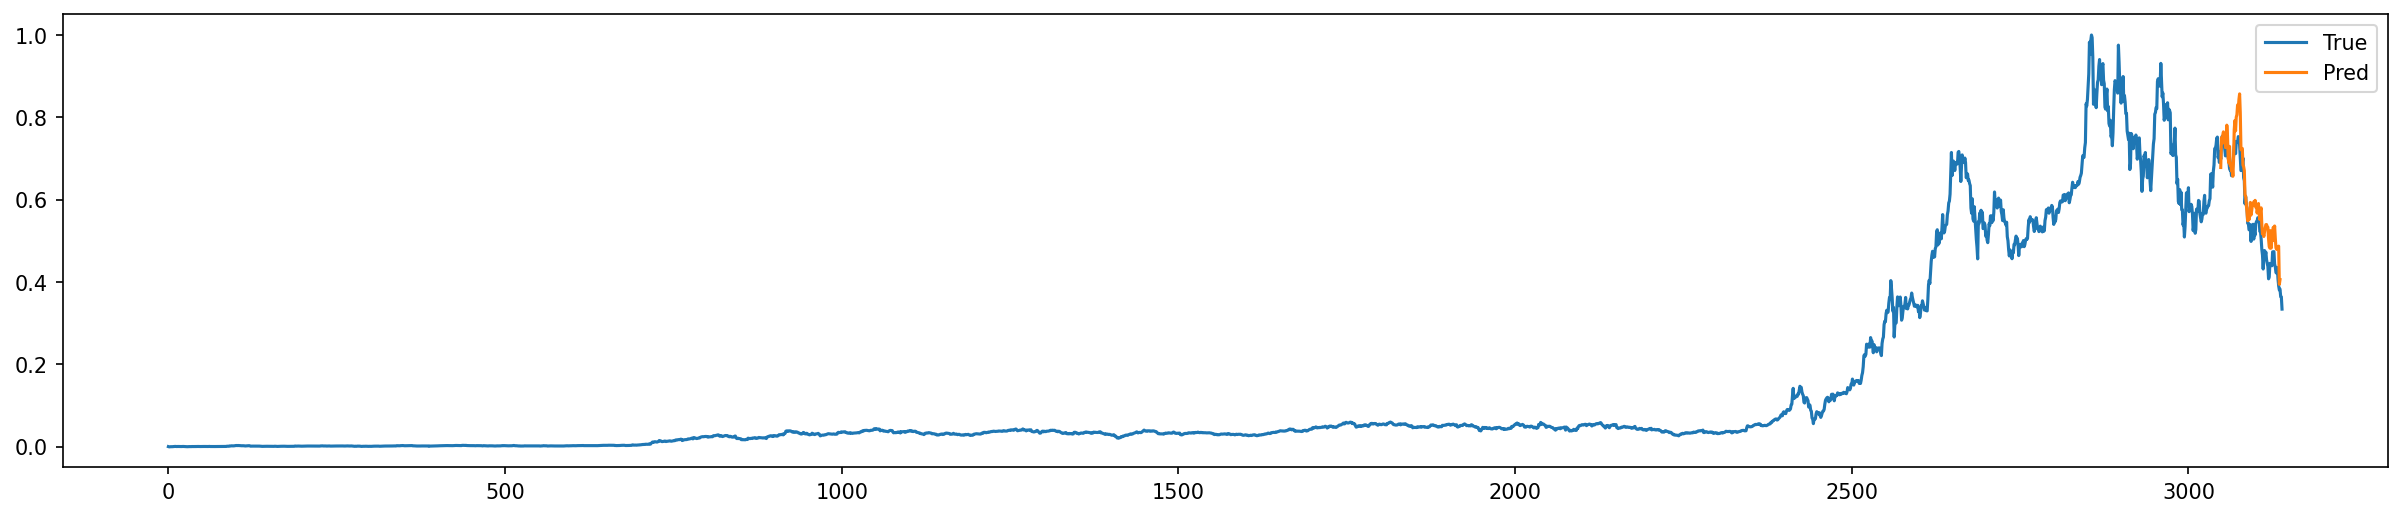

In [13]:
prediction = pd.DataFrame(pred, index=y_test.index)

sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(data['Close'], label = 'True')
plt.plot(prediction, label = 'Pred')

plt.legend()

plt.show()

# Interpretation of XGBoost

In [14]:
import ShapTimeBoosting
from ShapTimeBoosting import supertime, ShapleyValues, TimeImportance, TimeHeatmap

In [15]:
# The training set is evenly divided into 11 parts in the time dimension, 
# and the importance of each part is calculated.
Tn= 11
interp_x= x_train
model = model

ShapTime_xgb = ShapleyValues(model, interp_x, Tn)

In [16]:
ShapTime_xgb

[-0.03706724251298819,
 -0.036842581916623665,
 -0.03458163497274926,
 -0.02827137754726999,
 -0.027314816954946756,
 -0.028091340859074092,
 -0.022812499818047866,
 -0.023548940587285863,
 -0.018543947499889694,
 0.0898674889252106,
 0.16724870807518938]

In [17]:
# name these time periods
time_columns =  ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10']

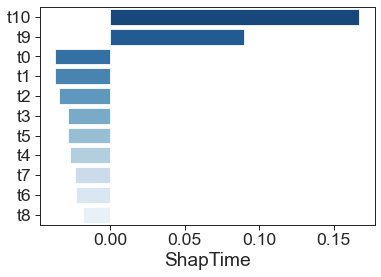

In [18]:
TimeImportance(Tn, ShapTime_xgb, time_columns)

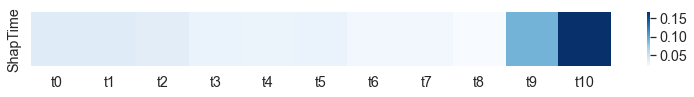

In [19]:
TimeHeatmap(Tn, ShapTime_xgb, time_columns)

# Evaluation of Interpretation

### Feature-Independence

In [20]:
import EvaluationBoosting
from ShapTimeBoosting import FeaIndepenVal, PlotVal

In [21]:
n = 5
Tn = 11
x_train_val = x_train.copy()
y_train = y_train
initial = ShapTime_xgb
model = xgboost.XGBRegressor()

In [22]:
result = FeaIndepenVal(x_train_val, y_train, initial, model, Tn, n, time_columns)

In [23]:
result

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
0,-0.037067,-0.036843,-0.034582,-0.028271,-0.027315,-0.028091,-0.022812,-0.023549,-0.018544,0.089867,0.167249
1,-0.037076,-0.036843,-0.034585,-0.028271,-0.027312,-0.028089,-0.022817,-0.023535,-0.018550,0.089862,0.167257
2,-0.037070,-0.036840,-0.034573,-0.028295,-0.027324,-0.028083,-0.022801,-0.023540,-0.018540,0.089849,0.167259
3,-0.037076,-0.036850,-0.034580,-0.028277,-0.027332,-0.028076,-0.022804,-0.023546,-0.018535,0.089854,0.167263
4,-0.037076,-0.036850,-0.034580,-0.028277,-0.027332,-0.028076,-0.022804,-0.023546,-0.018535,0.089854,0.167263
5,-0.037094,-0.036851,-0.034590,-0.028267,-0.027286,-0.028070,-0.022829,-0.023580,-0.018518,0.089807,0.167320


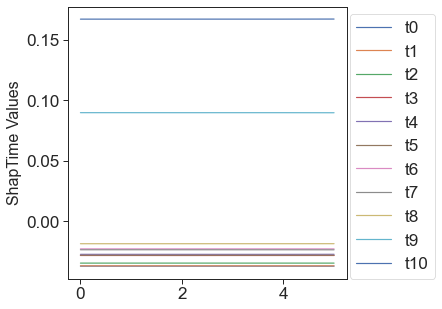

In [24]:
PlotVal(result)

### Sensitivity

In [25]:
situation_0 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
situation_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
situation_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 6, 8]

In [26]:
total = [situation_0, situation_1, situation_2]
train_eva = train.drop(columns = 'Date')
df_eva = supertime(11, train_eva)
model_eva = xgboost.XGBRegressor()

In [27]:
import EvaluationBoosting
from EvaluationBoosting import evaluation, R2Plot, MSEPlot

In [28]:
r2_results, mse_results = evaluation(df_eva, x_train, y_train, 'Close', model_eva, total)

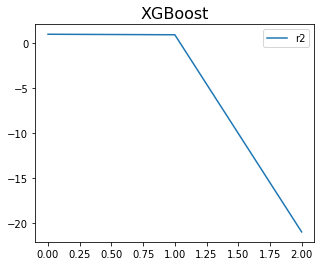

In [29]:
R2Plot(r2_results, 'XGBoost')

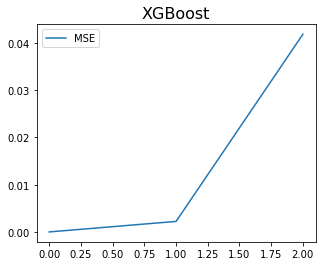

In [30]:
MSEPlot(mse_results, 'XGBoost')

# Improvement

In [31]:
for k in range(Tn):
    exec(f't{k} = supertime(Tn, train)[k]')

In [32]:
check_replist = [t0, t1, t2, t3, t4, t5, t6, t7, t10, t9, t10]

In [33]:
#check
check = pd.concat(check_replist, axis = 0)
x_check = check.drop(columns = {'Date', 'Close'}, axis = 1)
y_check = check.loc[:, ['Close']]

model_check = xgboost.XGBRegressor().fit(x_check, y_check)
pred_check = model_check.predict(x_test)

In [34]:
pred_check = slide_pred(3, pred_check)

In [35]:
r2_check = r2_score(pred_check, y_test)
mse_check = mean_squared_error(pred_check, y_test)

print(r2_check, 'Degree of Improvement: {:.2%}'.format((r2_check-r2)/abs(r2)))
print(mse_check, 'Degree of Improvement: {:.2%}'.format((mse-mse_check)/mse))

0.8198203757327401 Degree of Improvement: 7.42%
0.002155958257979649 Degree of Improvement: 26.18%


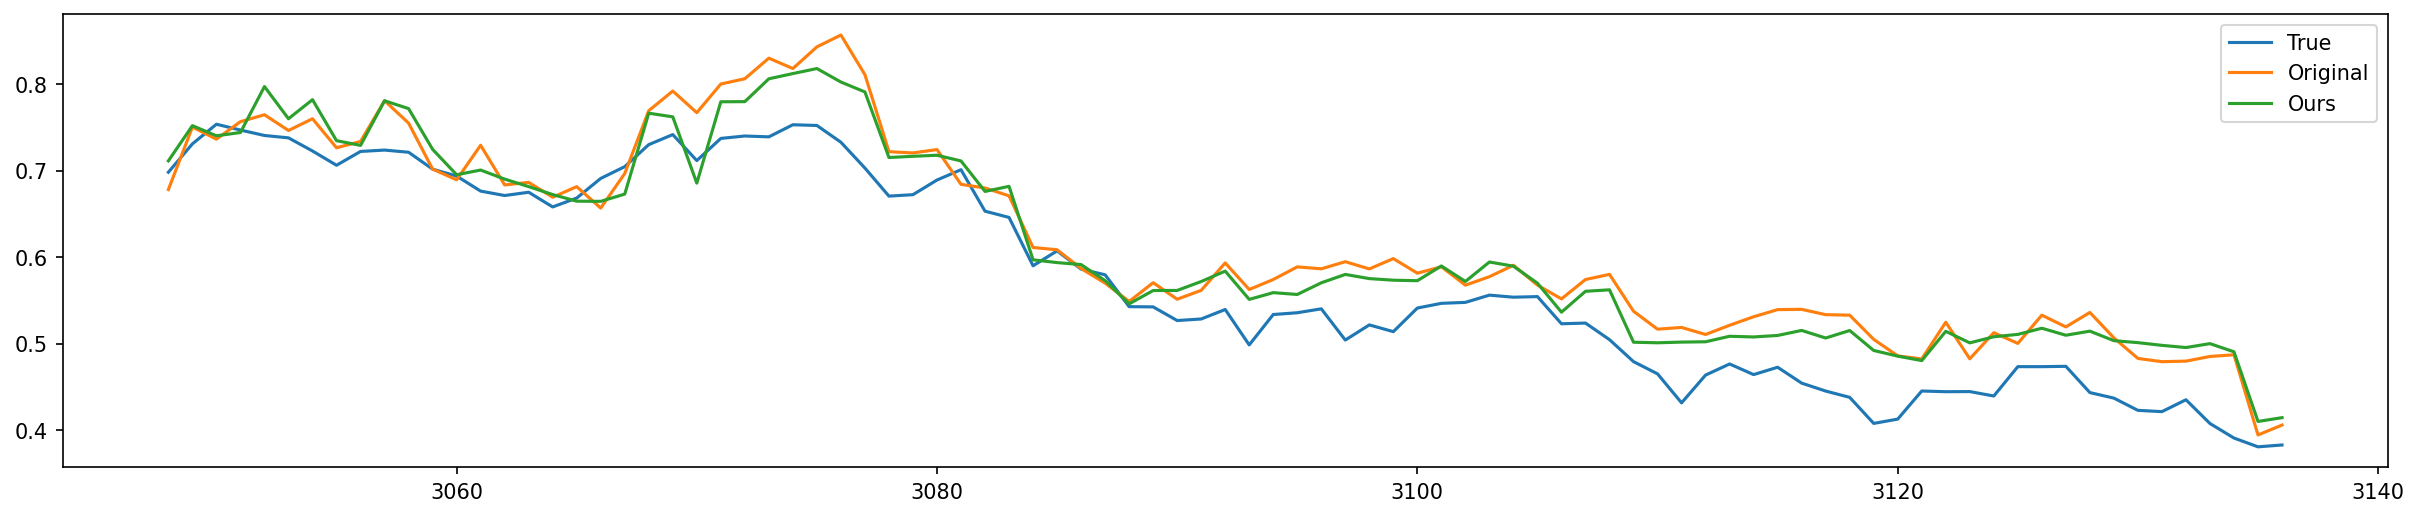

In [36]:
pred_our = pd.DataFrame(pred_check, index=y_test.index)


sns.reset_orig()
plt.figure(figsize = (20,4), dpi=150)

plt.plot(y_test['Close'], label = 'True')
plt.plot(prediction, label = 'Original')
plt.plot(pred_our, label = 'Ours')

plt.legend()

plt.show()